In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Conv1D,MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
fake = pd.read_csv('/content/drive/MyDrive/Dataset/Fake.csv')
real = pd.read_csv('/content/drive/MyDrive/Dataset/True.csv')

In [5]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [7]:
fake['subject'].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

<Axes: xlabel='subject', ylabel='count'>

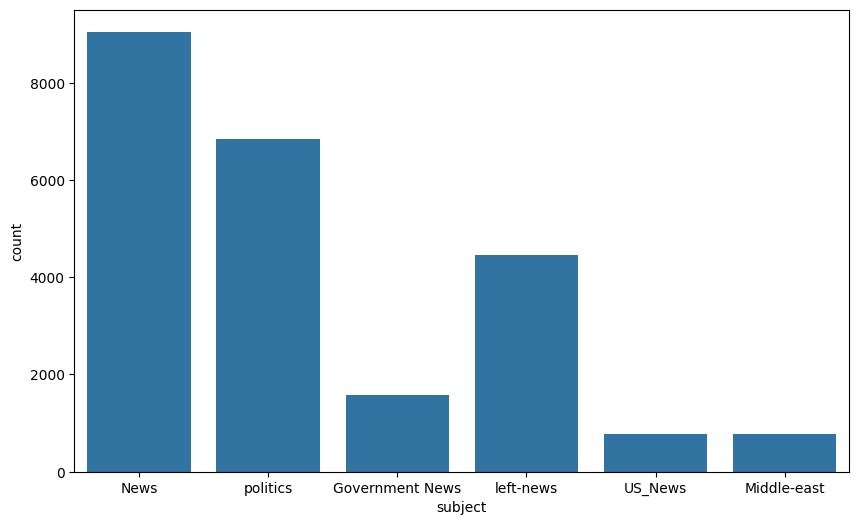

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject',data=fake)

Word Cloud


In [9]:
text = ' '.join(fake['text'].tolist())

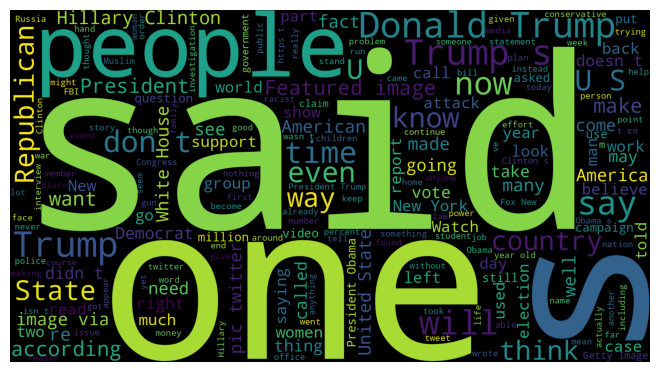

In [10]:
wordcloud = WordCloud(width=2000,height=1100).generate(text)

plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [11]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [12]:
real.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [13]:
real['subject'].value_counts()

subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

<Axes: xlabel='subject', ylabel='count'>

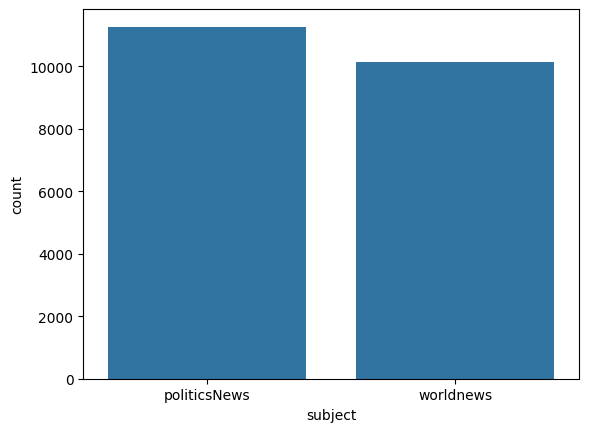

In [14]:
sns.countplot(x='subject',data=real)

In [15]:
text = ' '.join(fake['text'].tolist())

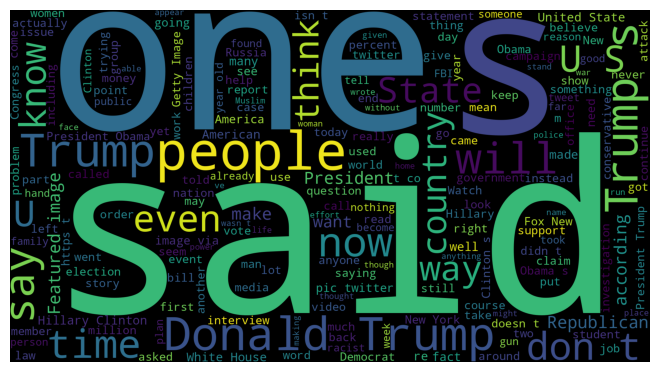

In [16]:
wordcloud = WordCloud(width=2000,height=1100).generate(text)

plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Data Cleaning


In [17]:
real.sample(5)

,title,text,subject,date
17300,Spanish High Court remands in custody two Cata...,MADRID (Reuters) - Spain s High Court said on ...,worldnews,"October 16, 2017"
17075,Turkey's Erdogan says may shut Iraqi border an...,ISTANBUL (Reuters) - President Tayyip Erdogan ...,worldnews,"October 19, 2017"
11437,"Turkey to hire 110,000 new public servants in ...",ISTANBUL (Reuters) - Turkey s Prime Minister B...,worldnews,"December 24, 2017"
5573,Republican elders urge Trump's White House to ...,WASHINGTON (Reuters) - A group of elder Republ...,politicsNews,"February 8, 2017"
6152,"Trump is now president, but he still sees hims...",WASHINGTON (Reuters) - Donald Trump took over ...,politicsNews,"January 20, 2017"


In [18]:
unknown_publishers = []
for index ,row in enumerate(real.text.values):
  try:
    record = row.split(' - ',maxsplit=1)
    record[1]
    assert(len(record[0])<120)
  except:
    unknown_publishers.append(index)

In [19]:
len(unknown_publishers)

229

In [20]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 229, dtype: object

In [21]:
publisher = []
tmp = []

for index,row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp.append(row)
    publisher.append('Unknown')
  else:
    record = row.split(' - ',maxsplit=1)
    publisher.append(record[0].strip())
    tmp.append(record[1])

In [22]:
real['publisher'] = publisher
real['text'] = tmp

In [23]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [24]:
real.shape

(21417, 5)

In [25]:
empty_fake_index = [index for index,text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [26]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [27]:
real['text']=real['title'] + " " + real['text']
fake['text']=fake['title'] + " " + fake['text']

In [28]:
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

Preprocessing of Text


In [29]:
real['class'] = 1
fake['class'] = 0

In [30]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [31]:
real = real[['text', 'class']]
fake = fake[['text' , 'class']]

In [32]:
data = pd.concat([real, fake], ignore_index=True)

In [33]:
data

,text,class
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1
...,...,...
44893,mcpain: john mccain furious that iran treated ...,0
44894,justice? yahoo settles e-mail privacy class-ac...,0
44895,sunnistan: us and allied ‘safe zone’ plan to t...,0
44896,how to blow $700 million: al jazeera america f...,0


In [34]:
string = "Ge;ek * s:fo ! r;Ge * e*k:s !"
new_string = ""
for i in string:
  if(i.isalpha() or i.isdigit()):
    new_string+=i
print(new_string)

GeeksforGeeks


In [35]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4
!pip install textblob


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [36]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-0_qp1s8f
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-0_qp1s8f
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 96bf02872d9756f29d6cddb8aafaedcd2a39bbb4
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7603 sha256=2f9eae15513ecae0b24b9d3d8cfa0b20aa8585f5429e737b9927b30180606952
  Stored in directory: /tmp/pip-ephem-wheel-cache-_g_yql87/wheels/5c/94/34/99d5ff65e88b8d9a6c5e8d8652f2311d87790a61a1b7466e21
Successfully built preprocess-kgptalkie


In [37]:
import preprocess_kgptalkie as ps


In [39]:
data['text']=data['text'].apply(lambda x: ps.remove_special_chars(x))

In [40]:
import gensim

In [41]:
y = data['class'].values

In [42]:
X = [d.split() for d in data['text'].tolist()]

In [44]:
type(X[0])

list

In [50]:
dim = 100
wordtovec = gensim.models.Word2Vec(sentences = X, vector_size=dim, window=10,min_count=1)

In [53]:
len(wordtovec.wv.index_to_key)

231902

In [54]:
wordtovec.wv['modi']

array([-1.4542454 , -0.00795834, -2.1282198 ,  1.076314  ,  0.5865447 ,
       -0.8025993 , -2.5996644 ,  0.5894595 , -2.1684716 ,  0.47682944,
        0.7796729 ,  0.9157214 , -1.6622487 , -0.43208766, -0.33471635,
        0.8916595 ,  2.0634274 ,  0.7965512 , -0.41872644, -0.19703999,
        0.7597791 ,  0.1384483 , -0.55251414,  1.0635269 , -0.5048309 ,
        0.7631172 ,  1.0607558 ,  0.03082266, -0.4256306 ,  0.7195691 ,
        1.0366915 , -0.47211212,  0.33633286, -0.81037736,  1.9262085 ,
        1.105202  , -0.02110247,  0.33171624, -0.1126288 ,  0.33844718,
        1.1001898 , -2.9423406 , -0.45678258,  0.30985555,  0.9609244 ,
        0.8503791 , -0.58691144,  1.0627161 , -0.12623164, -0.06618476,
       -0.46644035, -0.9666129 ,  0.7667123 , -0.21978907, -0.40665218,
        0.51031303, -0.29597765,  2.0941558 , -0.43931594, -0.19070347,
       -0.45799863,  0.8258755 , -0.07494629, -0.73234135,  0.8276727 ,
        0.06300922, -0.13108061,  0.6285009 ,  0.5480103 ,  0.20

In [55]:
wordtovec.wv.most_similar('modi')

[('narendra', 0.7937303781509399),
 ('modis', 0.627875804901123),
 ('india', 0.586959958076477),
 ('abe', 0.5717920064926147),
 ('volodymr', 0.5523933172225952),
 ('trudeau', 0.5517375469207764),
 ('usindia', 0.5462480187416077),
 ('bharatiya', 0.5352060794830322),
 ('indias', 0.5321698784828186),
 ('japans', 0.52895587682724)]

In [57]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [58]:
X = tokenizer.texts_to_sequences(X)

In [60]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'he': 12,
 'said': 13,
 'trump': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'his': 19,
 'by': 20,
 'has': 21,
 'be': 22,
 'have': 23,
 'not': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'us': 30,
 'an': 31,
 'they': 32,
 'i': 33,
 'but': 34,
 'we': 35,
 'would': 36,
 'president': 37,
 'about': 38,
 'will': 39,
 'their': 40,
 'had': 41,
 'you': 42,
 't': 43,
 'been': 44,
 'were': 45,
 'people': 46,
 'more': 47,
 'or': 48,
 'after': 49,
 'which': 50,
 'she': 51,
 'her': 52,
 'one': 53,
 'if': 54,
 'its': 55,
 'out': 56,
 'all': 57,
 'what': 58,
 'state': 59,
 'when': 60,
 'new': 61,
 'also': 62,
 'up': 63,
 'there': 64,
 'over': 65,
 'no': 66,
 'house': 67,
 'donald': 68,
 'our': 69,
 'states': 70,
 'clinton': 71,
 'obama': 72,
 'government': 73,
 'can': 74,
 'just': 75,
 'him': 76,
 'so': 77,
 'than': 78,
 'republican': 79,
 'other': 80,
 'so

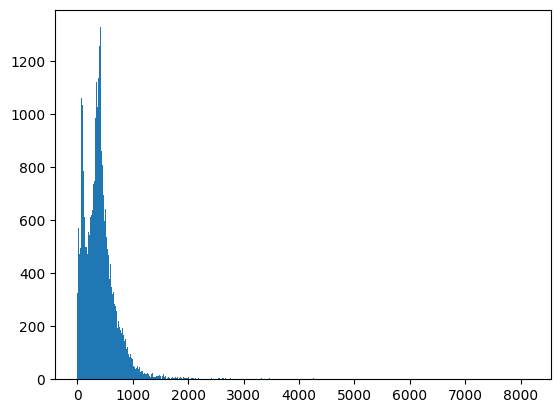

In [63]:
plt.hist([len(x) for x in X], bins=700)
plt.show()

In [64]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000])

1584

In [68]:
maxlen = 1000
X = pad_sequences(X,maxlen=maxlen)

In [71]:
len(X[305])

1000

In [73]:
vocab_size = len(tokenizer.word_index)+1
vocab = tokenizer.word_index

In [78]:
def get_weight_matrix(model):
  weight_matrix= np.zeros((vocab_size,dim))
  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix


In [79]:
embedding_vectors = get_weight_matrix(wordtovec)

In [80]:
embedding_vectors.shape

(231903, 100)

Model creation

In [81]:
model = Sequential()
model.add(Embedding(vocab_size,output_dim=dim,weights=[embedding_vectors],input_length=maxlen,trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])

In [82]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         23190300  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 23307677 (88.91 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 23190300 (88.46 MB)
_________________________________________________________________


In [98]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [99]:
model.fit(X_train,y_train,validation_split=0.3,epochs=6)

Epoch 1/6
737/737 [==============================] - 28s 39ms/step - loss: 0.0065 - acc: 0.9978 - val_loss: 0.0055 - val_acc: 0.9977
Epoch 2/6
737/737 [==============================] - 29s 39ms/step - loss: 0.0029 - acc: 0.9993 - val_loss: 0.0043 - val_acc: 0.9983
Epoch 3/6
737/737 [==============================] - 29s 39ms/step - loss: 3.4665e-04 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 0.9986
Epoch 4/6
737/737 [==============================] - 28s 38ms/step - loss: 9.2976e-05 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 0.9986
Epoch 5/6
737/737 [==============================] - 28s 38ms/step - loss: 5.4743e-05 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 0.9985
Epoch 6/6
737/737 [==============================] - 29s 40ms/step - loss: 3.5639e-05 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 0.9985


In [100]:
y_pred = (model.predict(X_test) >=0.5).astype(int)

351/351 [==============================] - 5s 13ms/step


In [101]:
accuracy_score(y_test,y_pred)

0.9985746102449888

In [102]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5803
           1       1.00      1.00      1.00      5422

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [112]:
x = ['BJP chief Jagat Prakash Nadda will likely be sworn in as a minister in the Narendra Modi government on Sunday. He will likely take oath of office along with the Prime Minister-elect and the latter`s council of ministers.']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,maxlen=maxlen)
(model.predict(x) >=0.5).astype(int)

1/1 [==============================] - 0s 28ms/step


array([[1]])